In [1]:
#Studnet: Jhuma kabir meem
#Exercise Cuda reduction


In [2]:
# -- initialize the device
# !pip install pycuda
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import numpy as np
from pycuda import driver, compiler, gpuarray, tools
import pycuda.autoinit

Array of floar number:  [[-0.42504275  0.07831261 -0.7431504  ...  1.798733    1.4251642
  -0.3080452 ]]
CPU Average processing time after 100 iteration = 0.174322s
GPU average processing time after 100 iteration wihout  shared memory = 0.042046s
GPU average processing time after 100 iteration using shared memory = 0.022986s


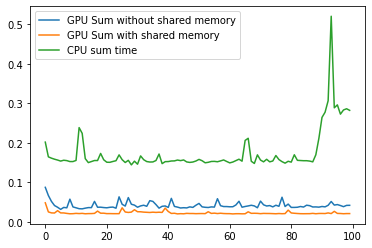

In [35]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt
import time


start = cuda.Event()
end  = cuda.Event()

size=16

A = np.random.randn(1,1024).astype(np.float32) # delcare array 
a = gpuarray.to_gpu(A)

cpu_times=[]
cpu_time_sum=0
for i in range(100):
  cpu_sum=0
  start_time = time.time()
  for x in A[0]:
    cpu_sum=cpu_sum=+x;

  times= time.time() - start_time
  cpu_time_sum = cpu_time_sum + times
  cpu_times.append(times*1000)




print('Array of floar number: ',A)

print("CPU Average processing time after 100 iteration = %fs" % (cpu_time_sum/100*1000))


# GPU sequential sum without shared memory
mod = SourceModule("""
  __global__ void sum(float * results, float * xs)
{
    int index = threadIdx.x + blockDim.x * blockIdx.x;
    int tx  = threadIdx.x;


    for (unsigned int s = blockDim.x / 2; s > 0; s >>= 1)
    {
        if (tx < s)
        {
            xs[index] += xs[index + s];
        }
        __syncthreads();        
    }


    if (tx == 0)
    {
        results[blockIdx.x] = xs[index];
    }
}
    """)


squential_shared_memory_processing_time=0
ssmpt1=[]

# run programme 100 times for without shared memory
for i in range (100):
  sum= np.zeros(5).astype(np.float32)
  sum = gpuarray.to_gpu(sum)
  start.record()
  func = mod.get_function("sum")
  func( sum, a ,  block=(size, 1, 1))
  end.record() 
  end.synchronize()
  secs = start.time_till(end) 
  squential_shared_memory_processing_time=squential_shared_memory_processing_time+secs
  ssmpt1.append(secs)


print("GPU average processing time after 100 iteration wihout  shared memory = %fs" % (squential_shared_memory_processing_time/100))


# GPU sequential sum with shared memory

mod = SourceModule("""
__global__ void sum(float * results, float * xs)
{
   
    extern __shared__ float sdata[];

    int index = threadIdx.x + blockDim.x * blockIdx.x;
    int tx  = threadIdx.x;

    sdata[tx] = xs[index];
    __syncthreads();            


    for (unsigned int s = blockDim.x / 2; s > 0; s >>= 1)
    {
        if (tx < s)
        {
            sdata[tx] += sdata[tx + s];
        }
        __syncthreads();        
    }

    if (tx == 0)
    {
        results[blockIdx.x] = sdata[0];
    }
}
   """)

squential_shared_memory_processing_time=0
ssmpt2=[]
# run programme 100 times for shared memory
for i in range (100):
  sum= np.zeros(5).astype(np.float32)
  sum = gpuarray.to_gpu(sum)
  
  start.record()
  func = mod.get_function("sum")
  func( sum, a ,  block=(size, 1, 1), shared=(size * 1))
  end.record() 
  end.synchronize()

  secs = start.time_till(end) 
  squential_shared_memory_processing_time=squential_shared_memory_processing_time+secs
  ssmpt2.append(secs)


print("GPU average processing time after 100 iteration using shared memory = %fs" % (squential_shared_memory_processing_time/100))


y0= plt.plot(ssmpt1, label='First Line')
y1=plt.plot( ssmpt2, label="cosine")
y3=plt.plot(cpu_times)

plt.gca().legend(('GPU Sum without shared memory','GPU Sum with shared memory','CPU sum time'))
